# Compression d'image

In [32]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Introduction au modèle de Potts

Le **modèle de Potts** permet d'introduire une notion de voisinage et modélise ainsi l'intéraction d'un individu sur ses voisins. En effet ce modèle est une généralisation du **modèle d'Ising** qui associe un état (binaire dans ce cas) aux individus qui intéragissent localement les uns entre les autres. Ainsi, à partir d'individus dispersés, on modélise des phénomènes collectifs. Le modèle de Potts permet de généraliser ce modèle à K états différents que peuvent prendre les individus.

Ici, la nuance d'un pixel influencera la nuance de ses pixels adjacents. Le choix du modèle de Potts est donc pertinent dans la compression d'image puisqu'en choisissant K on réduit le nombre de nuances que les pixels peuvent prendre tout en conservant la logique de l'image. 
Ainsi dans un tel modèle, un individu x est à valeurs dans $\{1 ... K\}^{n}$ et sa probabilité est : 

$$\pi(x) = \frac{1}{Z(\beta)}\exp [\beta \sum_{i \sim j} \mathbb{1}(x_i=x_j)]
\tag{1}$$

avec $i \sim j$ la relation de voisinage (on choisira les pixels adjacents dans notre cas).
$\beta$ peut être décrit comme un "facteur de rationalité" de sorte que si $\beta \rightarrow 0$, l'influence entre les individus est nulle et ne joue aucun rôle dans l'affectation un état _k_. A l'inverse si $\beta \rightarrow +\infty$, la relation de voisinage joue un rôle déterministe dans l'affectation aux états _k_. Ici, un $\beta$ faible donnera une image avec des couleurs relativement dispersée et beaucoup de "petits blocs" alors qu'un $\beta$ élevé donnera une image avec un grand bloc par couleur.

**Constante de normalisation** :

Afin que les probabilités des $\pi (x)$  prennent leurs valeurs dans [0,1], il est nécessaire de diviser par une constante de normalisation, qui s'exprime comme la somme pour toutes les valeurs possibles de x de ces probabilités.

La constante de normalisation de la probabilité $\pi (x)$ s'écrit donc comme :
$$Z(\beta) = \sum_{x \in {1 ... K}} \exp  [ \beta \sum_{i=1}^n \sum_{j\ne i} \mathbb{1}(x_i=x_j) \mathbb{1}(i \sim j) ]
\tag{2}$$







## Présentation du Gibbs Sampling 

Plaçons nous dans le cadre où nous disposons d'un jeu de données $(y_i)_{1:n}$ et que nous voulons générer les paramètres $(\theta_i)_{i=1..p}$ d'un modèle. Il se trouve alors que nous ne connaissions pas la loi jointe de $(y,\theta_1,\theta_2...,\theta_p)$ , mais que nous avons accès aux **lois conditionnelles**  $(\theta_i | \theta_1,...,\theta_{i-1},\theta_{i+1}...,y_{1:n})_{i=1..p}$. 

Dès lors, l'algorithme de Gibbs fonctionne comme suit :
 

> 1. On initialise $(\theta_1^{(0)},...,\theta_p^{(0)})$ \\

> 2. Pour $t=1$ jusqu'à ``n_iter`` : \\

* on génère $\theta_1^{(t)}\text{ selon } p(\theta_1 | \theta_1^{(t-1)},\theta_2^{(t-1)},\theta_3^{(t-1)},...,y_{1:n})$

...


* on génère $ \theta_i^{(t)}\text{ selon } p(\theta_i | \theta_1^{(t)},...,\theta_{i-1}^{(t)},\theta_{i+1}^{(t-1)}...,y_{1:n})$


  ...


* on génère $\theta_n^{(t)}\text{ selon } p(\theta_n | \theta_1^{(t)},...,\theta_{n-1}^{(t)},\theta_n^{(t-1)},y_{1:n}))$ \\

&nbsp;

Pour chacun des cas étudiés, il s'agit alors d'identifier les paramètres à estimer, les données et ainsi calculer les lois conditionnelles. 




_**Remarque**_ : Jusqu'à mention du contraire, $\beta$ sera considéré comme un paramètre connu que nous fixerons. Nous étudierons plus tard la possibilité d'estimer sa valeur. 

## Question 1 : Gibbs Sampler pour simuler selon la loi de Potts


#### Définissons tout d'abord une fonction permettant d'obtenir les voisins d'un individu _i_ dans une grille de taille $\sqrt n$ x $\sqrt n$

In [33]:
def voisins_i(i,sqrt_n) : 
    res = []
    if i % sqrt_n == 0: #si l'élèment i est au bord gauche de la grille 
        L = [i+1  , i+ sqrt_n, i-sqrt_n] #on ajoute son voisin de droite, d'en bas et d'en haut
    elif i % sqrt_n == sqrt_n-1: #si l'élèment i est au bord droit de la grille 
        L = [i-1 , i+ sqrt_n, i-sqrt_n] #on ajoute son voisin de gauche, d'en bas et d'en haut
    else :  #si l'élèment i est n'est pas sur un bord latéral 
        L = [i+1, i-1 , i+ sqrt_n, i-sqrt_n] #on ajoute ses 4 voisins
    for j in L :
        if j<sqrt_n**2 and j>= 0 : #on ne garde que les éléments contenus dans la grille  
        #par ex : si l'élèment est en bas ou en haut de la grille, l'ajout de son voisin d'en bas 
        #ou d'en haut n'est pas dans la grille)
            res.append(j)

    return(res)


#### Définissons maintenant la loi conditionnelle de $x_i$ sachant les autres paramètres du modèle. 

Cette fonction sera réutilisée dans la deuxième partie du travail et a donc différentes paramétrisations possibles. 


>Rappelons tout d'abord les **formules de Bayes** utilisées pour tous les calculs des lois conditionnelles et proportionnelles : 

&nbsp;



$$\pi (\theta \vert x) = \frac {f( x \vert \theta)\pi (\theta)}{\int_{\Theta} f( x \vert \theta)\pi (\theta) d \theta}$$ 

&nbsp;

$$\pi (\theta \vert x) \propto f( x \vert \theta)\pi (\theta)$$ \\

avec $\theta$ (à valeurs dans $\Theta$), le paramètre à estimer et $f$ la densité de la loi conditionnelle de $X$ sachant $\theta$.





* **Dans la première partie du travail**, nous souhaitons simuler des $X_i$ suivant le modèle de Potts.

Ainsi nous conditionnons les $X_i$ par ses semblables $X_{-i}$ et obtenons ainsi la loi suivante : 

$\forall  i\in (1,...,n)$ :

$$
( x_{i} \vert x_{-i}) \sim  \mathcal{M}((\frac{\pi(x_i=k,x_{-i})}{\sum_{j=1}^{K}\pi(x_i=j,x_{-i})}))
\tag{3}
$$

En effet les $X_i$ conditionnés aux  $X_{-i}$ suivent une loi multinomiale à K résultats possibles dont les probabilités $p_{i}$ sont données par :$\frac{\pi(x_i=k,x_{-i})}{\sum_{j=1}^{K}\pi(x_i=j,x_{-i})}$. 

&nbsp;


* **Dans la deuxième partie du travail**, notre modèle implique plus de paramètres à estimer. Dès lors, la loi conditionnelle de $X_i$ se généralise à ces paramètres de sorte que la loi de $X_i$ sachant $X_{-i}$, $\theta = (\mu,\sigma)$ et $Y$ est : \\

$\forall  i\in (1,...,n)$ et $k \in \{1...K\}$ : \\


$$ ( x_{i} \vert x_{-i}, \theta,y) = ( x_{i} \vert x_{-i}, \theta_k,y_i) \sim  \mathcal{M}(\pi(x_{i} = k \vert x_{-i})\pi(y_{i} = k \vert x_{i} = k, \theta_k)) 
\tag{4}$$ \\

La probabilité $\pi( x_{i} =k \vert x_{-i}, \theta,y)$ s'obtient à partir de $(3)$ multipliée par un facteur multiplicatif $\pi(y_{i} = k \vert x_{i} = k, \theta_k)$, *ie* la densité de $y_i$ conditionnelle donnée dans l'énoncé. Dans le code, cette densité est notée ``weights``. 

Les deux lois citées précédemment sont implémentées grâce à la fonction ``ratio_potts``.

Finalement dans la première partie du travail nous prendrons ``weights`` = 1 et dans la seconde nous prendrons donc ``weights`` = _densité conditionnelle de $Y_i$_. 



In [34]:
 def ratio_potts(x, i, k, weights) :
  #prend une liste de taille n-1 (on enlève le i_ème) 
  #et on calcule la proba que le i eme soit égal à k sachant les n-1 autres

    voisins = voisins_i(i = i, sqrt_n=sqrt_n)
    list_num = []
    
    if weights == False :
        w = [1] * K  # cas où nous générons seulement les X_i 
    else : 
        w = weights # cas où nous générons les X_i, les mu_k et les sigma_k
    for l in range(1, K+1):
        pi_l = 0 
        for vois in voisins : 
            if x[vois] == l :
                pi_l +=  1
        pi_l = pi_l * beta
        pi_l = np.exp(pi_l) * w[l-1]
        list_num.append(pi_l)

    return(list_num[k-1]/np.sum(list_num))


La fonction ``generate_potts`` retourne ainsi un $k \in \{1...K\}$ associée à la donnée $X_i$ selon le modèle de Potts. 



In [35]:
def generate_potts(x, i, weights) : 
    probas = []
    for k in range(1, K+1): 
        probas.append(ratio_potts(x=x, i=i, k=k, weights=weights))
        
    return(np.argmax(np.random.multinomial(1, probas))+1)



### Simulation des $X_i$ selon le modèle de Potts



Avant de commencer, nous devons également fixer les paramètres :
* $K$  : le nombre d'états possibles, 
* $\beta$ : le paramètre d'influence décrit en introduction, 
* $n$ la taille de notre grille 
* et ``n_iter`` le nombre d'itérations



In [36]:
K = 5 # K=2 : cas particulier du modèle d'Ising à deux états
beta = 1.2
n_iter = 30

n=32*32
sqrt_n = 32

#### Gibbs Sampler : 

Nous allons donc itérer sur les $X_i$ sachant les $X_{-i}$ grâce à la loi exprimée en $(1)$.

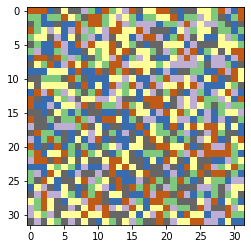

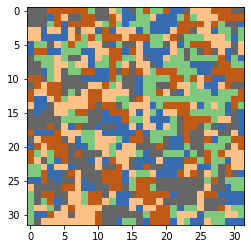

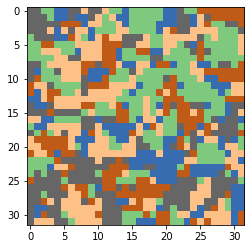

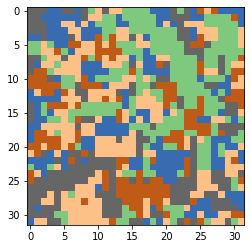

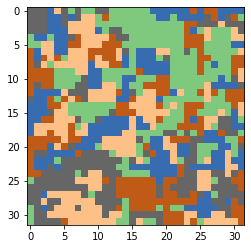

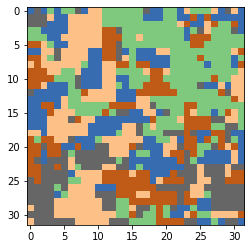

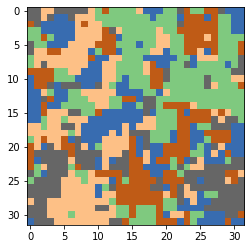

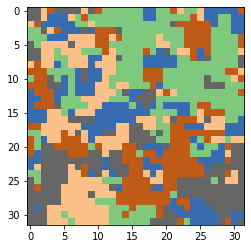

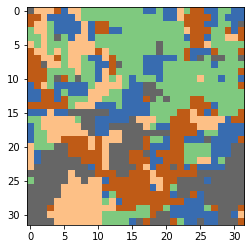

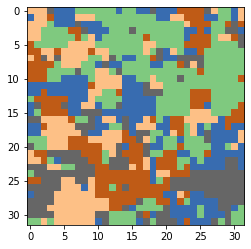

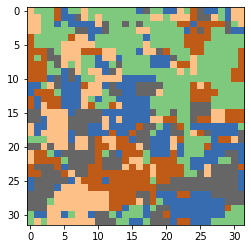

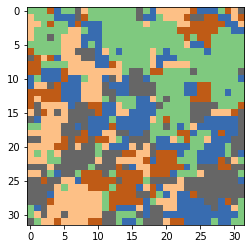

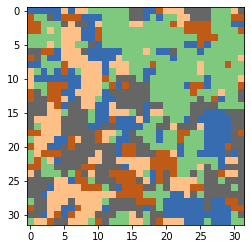

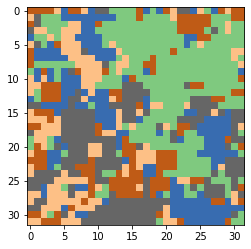

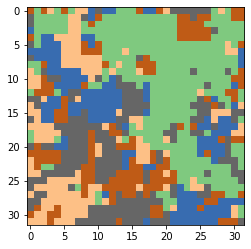

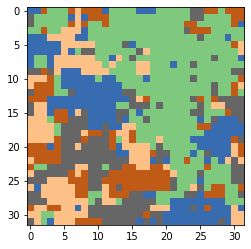

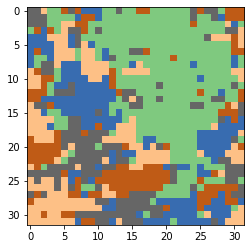

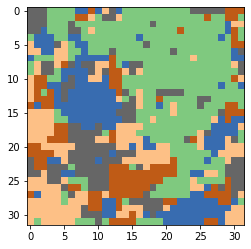

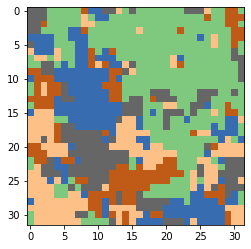

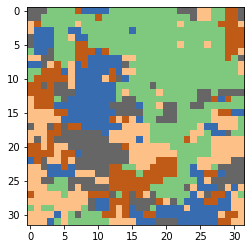

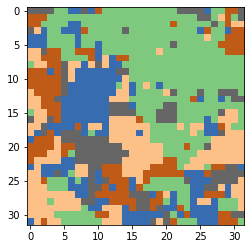

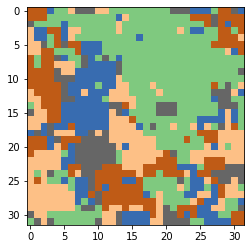

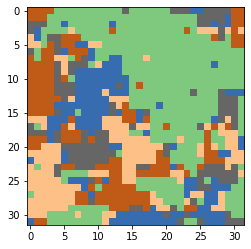

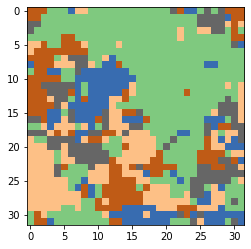

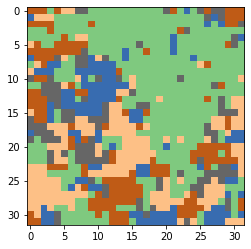

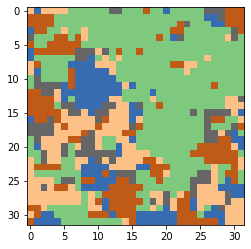

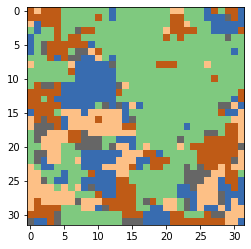

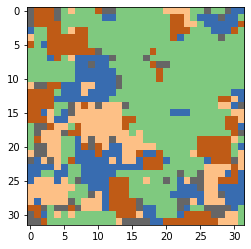

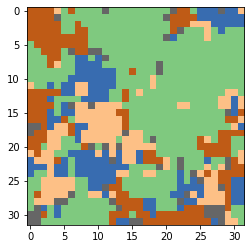

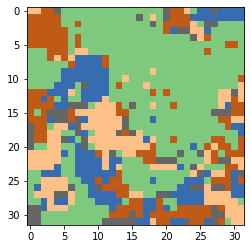

In [37]:
filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    plt.show()

On peut afficher l'évolution de nos simulations au fil de nos itérations sur les $X_{i}$ :

In [38]:
import imageio 
images = [] 
for filename1 in filename: 
        images.append(imageio.imread(filename1)) 
        imageio.mimsave('pott.gif', images)
plt.clf()
from IPython.display import Image
display(Image(url='pott.gif'))

<Figure size 432x288 with 0 Axes>

### Vérification de la pertinence de notre algorithme :

On choisit des paramètres un peu plus "lourds" (taille de l'image, nombre d'états) pour la visualisation pour vérifier nos performances.

**Attention : Les algorithmes sont donc assez longs au niveau des temps de calcul**. Il est possible de remplacer la taille de l'image (en # n = 16*16 et sqrt_n = 16 dans les codes) pour réduire les temps de calculs, cependant les performances sont alors quelquefois moins bonnes, et ne coincideront donc pas toujours avec les commentaires (aléas car chaque simulation est différente + taille de l'image réduite).

In [39]:
K = 10 # K=2 : cas particulier du modèle d'Ising à deux états
beta = 1
n_iter = 300

n=32*32
sqrt_n = 32
# n=16*16
# sqrt_n = 16

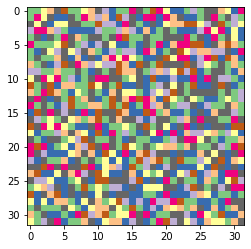

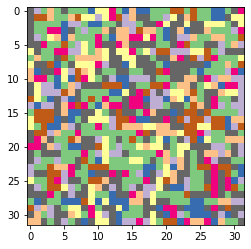

In [40]:
filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

In [41]:
X
sample = X[50:] # Après observations, on suppose que notre modèle a convergé au bout d'une cinquantaine d'itérations

In [42]:
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

#### **Séparation en sous-échantillons :**

Une première idée est que si notre algorithme converge bien, la distribution de n'importe quel fragment important de l'échantillon est une bonne approximation de la distribution visée. Ainsi si l'on découpe notre échantillon en deux sous échantillons, il devrait avoir une distribution similaire : on peut par exemple tester si les moyennes de ces échantillons sont significativement différentes. Si tel est le cas, notre algorithme semble ne pas être assez efficace.


In [43]:
#calcul de la moyenne d'un échantillon donnée : 
def mean(X):
    S=0
    for i in range (len(X)):
        S += X[i]
    S = S/(len(X))
    return S


On sépare l'échantillon en deux sous échantillons dont on compare les moyennes :

In [44]:
l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(M1-M2)

[-0.768 -0.224  0.4   ... -0.152 -0.328 -0.728]


Test de Welch pour savoir si les deux moyennes sont significativements différentes : H0 : M2-M1=0 contre H1 : M2-M1 $\ne$ 0.

In [45]:
stats.ttest_ind(M2,M1)

Ttest_indResult(statistic=4.705166551465546, pvalue=2.706267572349085e-06)

On ne peut pas rejetter H0 aux seuils habituels : ainsi les deux moyennes ne sont pas significativement différentes.

#### **Trace plot** :

On affiche l'évolution au fil des itérations d'un des coefficient $X_i$ du vecteur X :

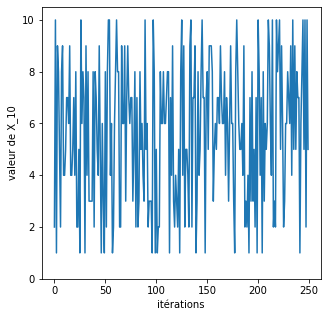

In [46]:
fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[10])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_10",fontsize=10)

plt.ylim(0,10.5)
#plt.savefig("traceplot.png")
plt.show()


D'après le traceplot, notre algorithme ne semble pas poser de problème et converger. En effet, la chaîne semble explorer l'entièreté de l'échantillon de nombreuses fois, et il semble y a avoir une légère (mais pas trop importante) corrélation entre les échantillons successifs. De plus, l'entièreté de l'échantillon présente les mêmes caractéristiques.
On ne rencontre donc ni un problème de corrélation trop importante - qui signifierait que l'échantillon n'est constitué que de peu d'observations indépendantes - ni une partie de l'échantillon différente du reste - signe d'une convergence au bout d'un certain temps dans le cas où les premiers élèments de l'échantillon sont très différents de la distribution visée.

#### Fonction d'autocorrélation:

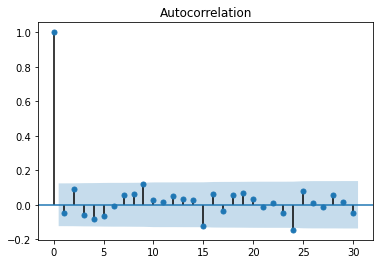

<Figure size 720x720 with 0 Axes>

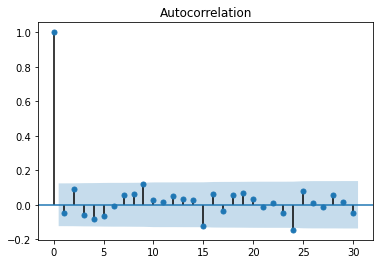

In [47]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
#acf = acf(X[:,2]) 
fig = plt.figure(figsize=(10, 10))
plot_acf(data_sample.iloc[10],lags=30)
#plt.savefig("autocorrelation.png")

L'affichage des autocorrélations montre qu'elle sont d'abord importante pour les premiers ordres mais converge vers 0 très rapidement. Il ne semble donc pas y avoir de problème d'autocorrélation.

## Influence des paramètres fixés

Il peut être intéressant d'étudier les performances de notre modèle conditionnellement aux paramètres sur lesquels on peut jouer.

**Attention :** ici on resimule à chaque fois notre Gibbs Sampling en jouant sur certains paramètres : les temps de calculs sont donc aussi assez longs. Comme précedemment, il est possible de remplacer la taille de l'image (en # n = 16*16 et sqrt_n = 16 dans les codes) pour réduire les temps de calculs, cependant les performances seront impactées.

### **Influence du nombre d'itérations dans notre simulation**

Il faut un certain nombre d'itérations afin que nos simulations convergent. A $\beta$ et K fixés, on peut regarder l'influence de ce nombre d'itérations sur la convergence.

**N=50**

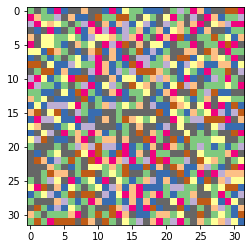

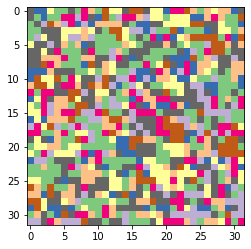

In [48]:
K = 10 
beta = 1
n_iter = 50 # variable sur laquelle on va jouer

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

Ttest_indResult(statistic=-2.3859477051305187, pvalue=0.01712563499178679)


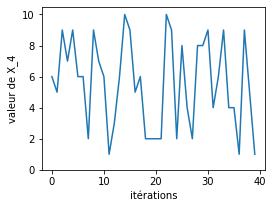

In [49]:
X
sample = X[10:] #Après observations, on suppose la convergence au bout de 10 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(4,3))
plt.plot(data_sample.iloc[4])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_4",fontsize=10)

plt.ylim(0,10.5)
plt.savefig("traceplot.png")
plt.show()

On rejette H0 a tout les seuils. Le trace plot semble lui ne pas parcourir l'ensemble des valeurs possibles de nombreuses fois : il semble y a avoir une corrélation un peu trop forte entre les vecteurs successifs. On n'observe pas de burn-in.

<Figure size 720x720 with 0 Axes>

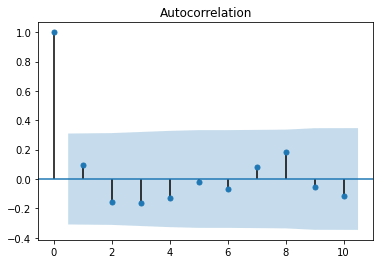

In [50]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(10, 10))
plot_acf(data_sample.iloc[4],lags=10)
plt.savefig("autocorrelation.png")

Les corrélations, bien que décroissantes, ne tendent pas directement vers 0. 
Ici notre modèle ne semble pas assez efficace. Il convient de voir l'impact de l'augmentation du nombre d'itérations, toutes choses égales par ailleurs.

**N=300**

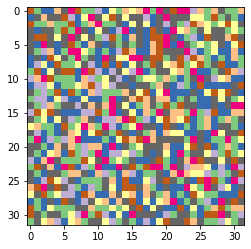

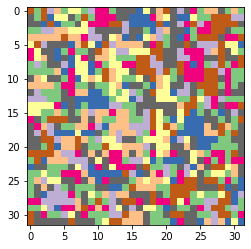

In [51]:
K = 10 
beta = 1
n_iter = 300 # variable sur laquelle on joue

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

Ttest_indResult(statistic=4.7090702118206735, pvalue=2.6555021927997877e-06)


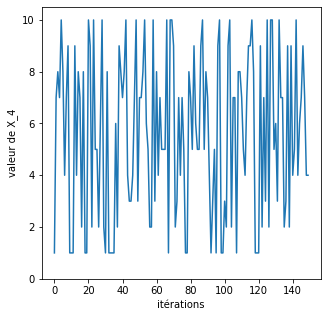

In [52]:
X
sample = X[150:] #on suppose la convergence au bout de 150 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[4])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_4",fontsize=10)

plt.ylim(0,10.5)
plt.savefig("traceplot.png")
plt.show()

<Figure size 360x360 with 0 Axes>

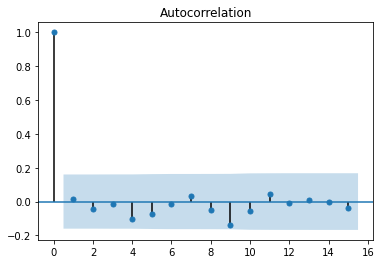

In [53]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(5, 5))
plot_acf(data_sample.iloc[4],lags=15)
plt.savefig("autocorrelation.png")

Notre modèle semble plus efficace : on ne peut rejetter H0. Le trace plot semble meilleur. Les corrélations décroissent rapidement et convergent vers 0. Ainsi, les autres paramètres étant fixés, augmenter le nombre d'itérations permet une meilleure convergence de notre échantillon vers la distribution visée.


### **Influence du paramètre $\beta$ :**

Comme précisé dans l'introduction, $\beta$ décrit en quelque sorte l'intensité de la relation de voisinage : un $\beta$ faible donnera une image avec des couleurs assez dispersée en nombreux "petits blocs" et à l'inverse un $\beta$ élevé donnera une image constitué de "grand bloc" par couleur. La valeur de ce paramètre peut ainsi considérablement changer nos simulations.
Dans la littérature, $\beta$ semble varier entre 0.5 et 1.5. Ici on test des valeurs un peu plus extrêmes pour observer les limites du paramètres.
On choisit un nombre suffisant d'itérations.



**$\beta = 4$ :**

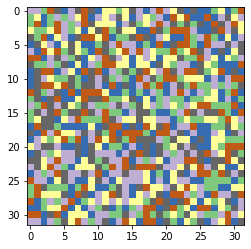

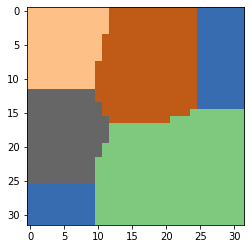

In [54]:
K = 5 
beta = 4 # variable sur laquelle on joue
n_iter = 300

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()


On obtient bien des "gros blocs" de couleurs, comme on pouvait s'y attendre avec une valeur de $\beta$ aussi élevée.

Ttest_indResult(statistic=-1.7342456311441692, pvalue=0.08302512774057932)


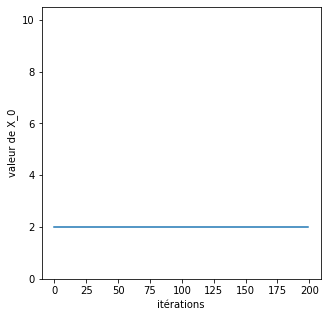

In [55]:
X
sample = X[100:] #Après observations, on suppose la convergence au bout de 100 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[0])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_0",fontsize=10)

plt.ylim(0,10.5)
plt.savefig("traceplot.png")
plt.show()

Ici on rejette H0, et les trace plot sont très mauvais et ne prennent souvent qu'une valeur : la valeur trop forte de $\beta$ induit une uniformisation de l'image, qui reste semblable d'une itération à l'autre : corrélation trop forte.
Ce modèle n'est donc pas performant. Il faudrait moins d'itérations pour ne pas aboutir à cette uniformité de l'image.

**$\beta$ = 1.5 :**

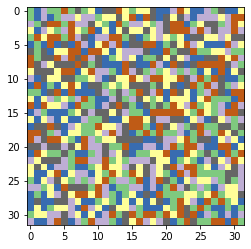

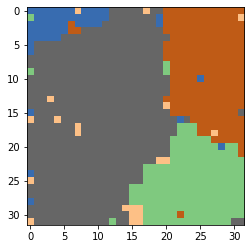

In [56]:
K = 5 
beta = 1.5 # variable sur laquelle on joue
n_iter = 300

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

$\beta$ reste important donc on conserve les "gros blocs", avec cependant un peu plus de "petit blocs" dispersés.

Ttest_indResult(statistic=4.399922599695662, pvalue=1.1385650122504959e-05)


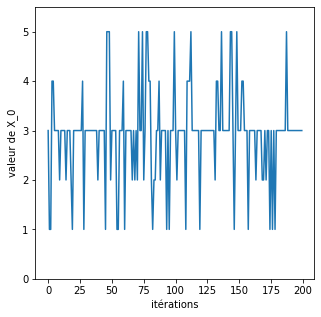

In [57]:
X
sample = X[100:] #on suppose la convergence au bout de 100 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[0])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_0",fontsize=10)

plt.ylim(0,5.5)
plt.savefig("traceplot.png")
plt.show()

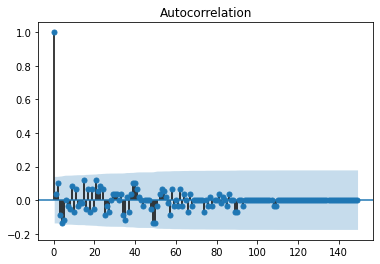

<Figure size 720x720 with 0 Axes>

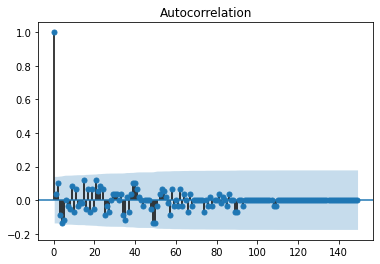

In [58]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(10, 10))
plot_acf(data_sample.iloc[4],lags=149)

La p-value est toujours trop faible. Cependant les trace plot et les autocorrélations sont meilleurs : le trace plot parcourt l'échantillon. La fonction d'autocorrélation semble présenter néanmoins des corrélations parfois importantes à des ordres élevés. 

$\beta$ influence la relation de voisinage donc sera crucial à paramétriser dans le cas où l'on cherchera à compresser une image donnée grâce aux simulations de nos $X_i$ suivant un modèle de Potts. Changer $\beta$ ne rend donc pas toujours compte de performances plus ou moins efficace de notre algorithme, il dépend des autres valeurs des paramètres et de l'image choisie.

**$\beta$ = 1 (cf performances de l'algorithme) : résultats bien meilleurs.**

**$\beta$ = 0.8:**

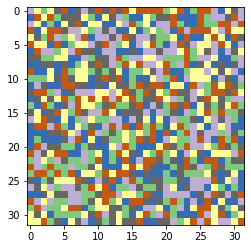

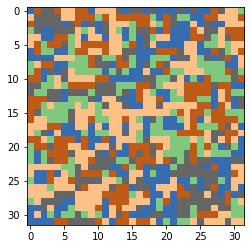

In [59]:
K = 5 
beta = 0.8 # variable sur laquelle on joue
n_iter = 300

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

Ttest_indResult(statistic=5.1160894039197276, pvalue=3.4106154388721084e-07)


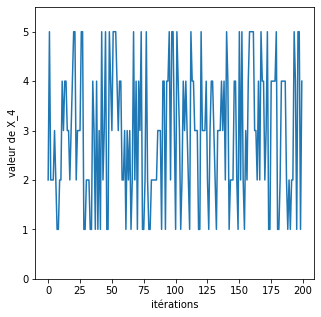

In [60]:
X
sample = X[100:] #Après observations, on suppose la convergence au bout de 100 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[4])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_4",fontsize=10)

plt.ylim(0,5.5)
#plt.savefig("traceplot.png")
plt.show()

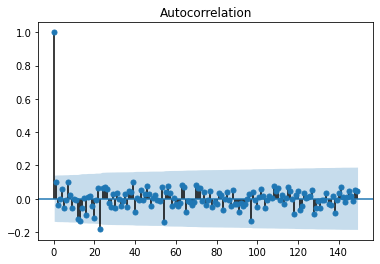

<Figure size 720x720 with 0 Axes>

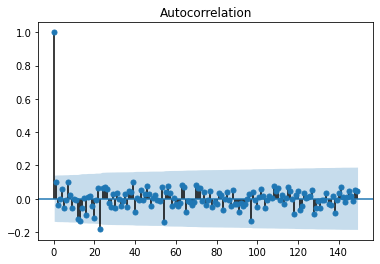

In [61]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(10, 10))
plot_acf(data_sample.iloc[4],lags=149)
#plt.savefig("autocorrelation.png")

Notre modèle semble ici meilleur au fur et à mesure qu'on réduit $\beta$ : ici les test sont satisfaisants. Cependant il s'agit d'une situation à K, n et n_iter fixé, ainsi d'autres cas de figure pourraient nous mener à augmenter $\beta$ pour améliorer les performances du modèle. 

Par exemple si l'on continue de réduire $\beta$ :

**$\beta$ = 0.5:**

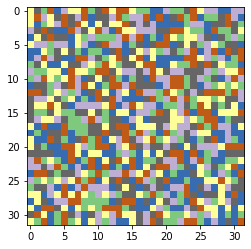

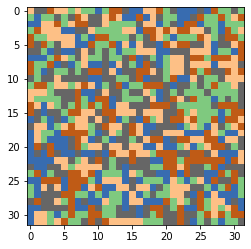

In [62]:
K = 5 
beta = 0.5 # variable sur laquelle on joue 
n_iter = 300

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

Ttest_indResult(statistic=-3.4279765411407124, pvalue=0.000620134867840784)


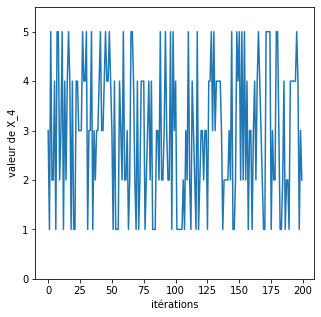

In [63]:
X
sample = X[100:] #on suppose la convergence au bout de 100 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[4])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_4",fontsize=10)

plt.ylim(0,5.5)
plt.savefig("traceplot.png")
plt.show()

<Figure size 720x720 with 0 Axes>

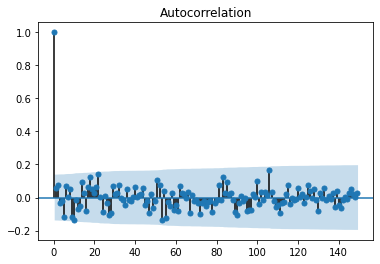

In [64]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
#acf = acf(X[:,2]) 
fig = plt.figure(figsize=(10, 10))
plot_acf(data_sample.iloc[4],lags=149)
plt.savefig("autocorrelation.png")

Un $\beta$ trop petit offre ainsi également des mauvaises performances de l'algorithme : ici on rejette le test de Welch (au seuil de 5%), les autocorrélations restent importantes. D'où l'importance de sa bonne paramétrisation, souvent à la main.

### **Influence du paramètre K:**

Le nombre K de valeur que peut prendre x, c'est-à-dire le nombre de dimension de l'espace des couleurs après compression, permet d'avoir un modèle plus ou moins simple (avec plus ou moins de couleurs).

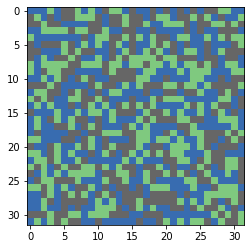

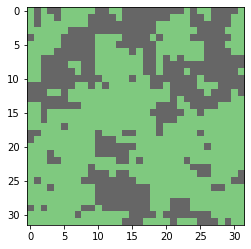

In [65]:
K = 2 # K=2 : cas particulier du modèle d'Ising à deux états
beta = 0.8
n_iter = 300

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

Ttest_indResult(statistic=-3.68947816682612, pvalue=0.00023058317336872717)


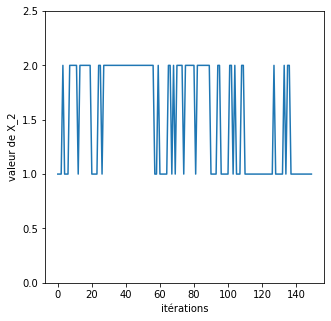

In [66]:
X
sample = X[150:] #on suppose la convergence au bout de 150 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[2])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_2",fontsize=10)

plt.ylim(0,2.5)
plt.savefig("traceplot.png")
plt.show()

Le modèle ne semble pas assez efficace : on rejette H0 (le fait de n'avoir que 2 possibilités pour K joue beaucoup). La trace plot parcourt néanmoins l'entièreté de l'échantillon à des multiples reprises.

<Figure size 720x720 with 0 Axes>

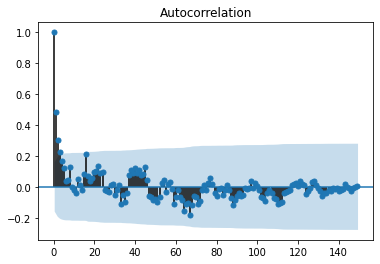

In [67]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
#acf = acf(X[:,2]) 
fig = plt.figure(figsize=(10, 10))
plot_acf(data_sample.iloc[4],lags=149)
plt.savefig("autocorrelation.png")

La fonction d'autocorrélation est décroissante mais ne s'annule pas au bout de quelques ordres : elle reste importantes pour des ordres élevés.

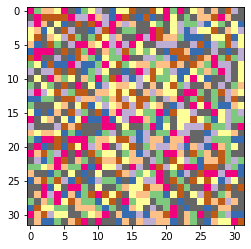

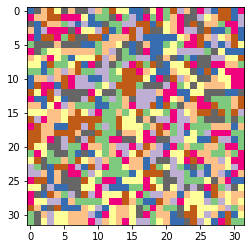

In [68]:
K = 8 # varaible sur laquelle on joue
beta = 0.8
n_iter = 300

n=32*32
sqrt_n = 32
#n=16*16
#sqrt_n = 16

filename = []
x = np.random.randint(K+1, size=n)
X = np.zeros((n_iter, n))
X[0, : ] = x.copy()
plt.imshow(X[0].reshape(sqrt_n,sqrt_n),cmap='Accent')
plt.savefig("potts_0.png")
plt.show()
filename.append('potts_%d.png' % 0)
for it in range(1, n_iter) :
    for i in range(n) :
        new_x_i = generate_potts(x, i, weights = False)
        x[i] = new_x_i
    X[it, :] = x
    filename.append('potts_%d.png' % it)
    plt.imshow(X[it].reshape(sqrt_n,sqrt_n),cmap='Accent')
    #plt.savefig("potts_%d.png" % it)
    #plt.show()

Ttest_indResult(statistic=-0.8164655041901928, pvalue=0.4143289945538854)


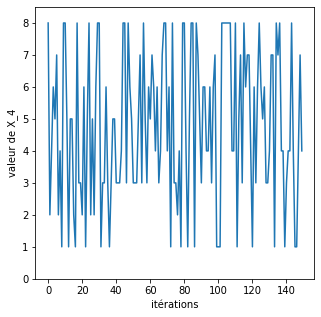

In [69]:
X
sample = X[150:] #Après observations, on suppose la convergence au bout de 150 itérations
data = pd.DataFrame(X)
data = data.transpose()
data_sample = pd.DataFrame(sample)
data_sample = data_sample.transpose()

l = len(sample)
chunk1 = sample[0:l//2]
chunk2 = sample[l//2:]

M1 = mean(chunk1)
M2 = mean(chunk2)
print(stats.ttest_ind(M2,M1))

fig = plt.figure(figsize=(5, 5))
plt.plot(data_sample.iloc[4])

plt.xlabel("itérations",fontsize=10)
plt.ylabel("valeur de X_4",fontsize=10)

plt.ylim(0,8.5)
plt.savefig("traceplot.png")
plt.show()

<Figure size 720x720 with 0 Axes>

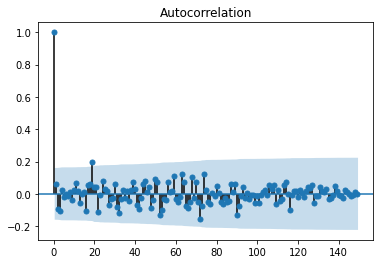

In [70]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf 
fig = plt.figure(figsize=(10, 10))
plot_acf(data_sample.iloc[4],lags=149)
plt.savefig("autocorrelation.png")

Le modèle semble légèrement plus satisfaisant : cependant les corrélations restent assez importantes pour certains ordres élevés.
Il faudrait éventuellement augmenter $n_{iter}$.

L'augmentation de K complexifie le modèle : il faut souvent plus d'itérations pour converger (mais cela dépend également de la valeur de $\beta$ : lorsque K est petit, on ne donne pas trop d'importance à la relation de voisinage de peur d'arriver à une image uniforme). Cependant intégrer plus de nuances (à horizon raisonnable) semble améliorer le modèle : en effet un modèle a seulement deux couleurs est rapidement dominé par un des deux états (pas de voisins d'autres couleurs pour contrebalancer). 

# Analyse d'images 

Considérons des images de taille $\sqrt n$ x $\sqrt n$ avec $n$ pixels décrits pas $(Y_i)$ : leurs nuances de gris. 

Il est classique de supposer :

$$
Y_i \vert X_i=k\sim \mathcal{N}( \mu_{k},\,\sigma_{k}^{2}) 
\tag{5}
$$ 

où les $X_i$ forment un modèle de Potts. 

Nos données sont ici les $Y_i$ (nuances des pixels de notre image). Nous cherchons donc à simuler la loi des variables latentes $X_i$ et des paramètres $\theta_k$ = ($\mu_k,\sigma_k^2$). 

### **Choix des lois a priori**

Afin de faciliter le calcul des lois conditionnelles, nous utilisons les lois a priori suivantes : 


* $$ \mu_{k} \sim \mathcal{N}(m_{k},\,s_{k})$$

* $$ \sigma_{k}^{2} \sim I\Gamma(\alpha_{k},\, \beta_{k})$$

* $$x_{i}\sim Potts (\text{cf.(1)})$$ 

### **Lois conditionnelles** 

Nous avons maintenant les informations nécessaires aux calculs des lois conditionnelles nécessaires au Gibbs Sampling. Celles-ci sont : 


* $$\text{cf.(5)} $$ \\

* $$( x_{i} \vert x_{-i}, \theta_k,y_i) \sim  \mathcal{M}(\pi(x_{i} = k \vert x_{-i})\pi(y_{i} = k \vert x_{i} = k, \theta_k)) (\text{cf.(4)}) $$ \\

* $\forall k \in (1,...,K)$ :

$$ (\sigma_{k}^2 \vert y, x, \mu_{k}) \sim I\Gamma(\alpha_{k} + \frac{n_{k}}{2},\, \beta_{k} + \sum_{i=1, x_{i}=k }^{n} \frac{(y_{i}- \mu_{k})^{2}}{2} ) 
\tag{6}$$

* $\forall k \in (1,...,K)$ :

$$ (\mu_{k} \vert y, x, \sigma_{k}^{2}) \sim \mathcal{N}( \Sigma_{k}^{2} F_{k},\,\Sigma_{k}^{2})
\tag{7} $$



>où $ \Sigma_{k}^{2} = \frac{(\sigma_{k} s_{k})^{2} }{\sigma_{k}^{2} + n_{k} s_{k}^{2} }  $, \\

>$ F_{k} = \frac{m_{k}}{ s_{k}^{2}} + \sum_{i=1, x_{i}=k }^{n} \frac{y_{i}}{\sigma_{k}^{2}} $, \\

> et  $ n_{k} = \# \left\{ i : x_{i} = k \right\} $ \\

**On chosit l'image à compresser, qu'on met en nuance de gris et dans la dimension choisie.**

In [71]:
from PIL import Image, ImageOps

In [73]:
img=Image.open("fleche.jpg") 
img.thumbnail((16,16), Image.ANTIALIAS)  
gray_image = ImageOps.grayscale(img)

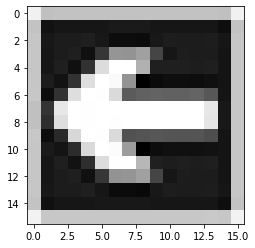

In [74]:
plt.imshow(gray_image,cmap='gray')

In [75]:
y = np.array(gray_image)
y = y.reshape(y.shape[0]*y.shape[1]) 

Définition de la densité de la loi normale : 

In [76]:
def norm_densite (x,mu,sigma_2):  
    norm = np.sqrt(2*np.pi*sigma_2)
    res = -(x-mu)**2/(2*sigma_2)
    return(norm**(-1)*np.exp(res))

### **On fixe les paramètres et on initialise nos variables à simuler :** 

In [115]:
# hyperparamètres
K = 10
beta = 5 #on choisit un beta très élevé car les couleurs de l'image sont très bien partitionnées
n_iter = 150
n=16*16
sqrt_n = 16

#initialisation et paramètres des lois à priori
#m = np.array([0.0]*K)
m = np.arange(0,256,256/K)
s = np.array([110]*K)
alphas =  np.array([1.0]*K)
betas = np.array([1.0]*K)
#x = np.random.randint(K+1, size=n)
x = ((y /256)*K).astype(int)+1

# on prépare les tableaux pour stocker les simulations
Mu = np.zeros((n_iter,K))
Sigma = np.zeros((n_iter,K))
X = np.zeros((n_iter, n))

Mu[0, :] = m.copy()
Sigma[0,:] = s.copy()
X[0,:] = x.copy()
w=[]

## **On implémente le Gibbs Sampler afin de simuler $X_i$, $\mu_k$, $\sigma_k^2$** :

In [116]:
for it in tqdm(range(1, n_iter)) :

  #on génère les x_i
  w=[]
  #on calcule les poids associés aux y_i
  for i in range(n):
    mu = Mu[it-1, x[i]-1].copy()
    sigma = Sigma[it-1, x[i]-1].copy()
    densité_y_i = stats.norm.pdf(y[i], loc = mu, scale =  sigma)*10

    w.append( densité_y_i )
  for i in range(n) :
    new_x_i = generate_potts(x, i, weights = w)
    x[i] = new_x_i.copy()
  X[it, :] = x.copy()

  # les mu_k et les sigma_k
  n_k = [np.sum(x==k) for k in range(1,K+1)]
  for k in range(K):
    F_k = 0
    Sigma_k = ( s[k] * Sigma[it-1, k] ) / ( Sigma[it-1, k] + s[k] * n_k[k] ).copy()

    F_k += (m[k] / s[k]).copy()
    F_k += (np.sum(y[x==(k+1)]) / Sigma[it-1, k]).copy()
    moy = (Sigma_k * F_k).copy()
    var = Sigma_k.copy()
    new_mu_k = (np.random.normal(loc = moy, scale= np.sqrt(var)))

    Mu[it, k] = new_mu_k

    new_alpha = (alphas[k] + n_k[k] / 2).copy()
    new_beta = (betas[k] + float(n_k[k])*np.sum((y[x==(k+1)] - new_mu_k)**2) / 2).copy()
    new_sigma_k = (stats.invgamma.rvs(new_alpha, scale = new_beta))

    Sigma[it, k] = new_sigma_k.copy()

    



100%|██████████| 149/149 [00:28<00:00,  5.23it/s]


**Evaluons les performances de notre simulation en regardant la convergence des paramètres d'intérêt, $\mu_k$ et $\sigma^{2}_k$. Comme pour la simulation de Potts on commence par obtenir les trace plots:**

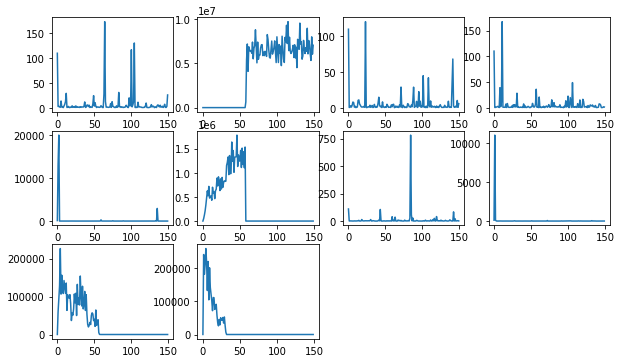

In [117]:
plt.figure(1, figsize=(10, 8))
for k in range (K):
    plt.subplot(4,4,k+1)
    plt.plot(Sigma[:,k])

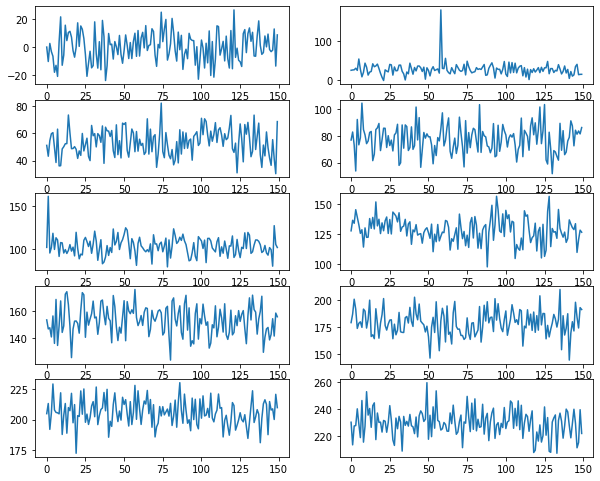

In [118]:
plt.figure(1, figsize=(10, 10))
for k in range (K):
    plt.subplot(6,2,k+1)
    plt.plot(Mu[:,k])

On remarque des valeurs extrêmes pour les sigma, on suppose d'après les observations et la littérature que c'est le cas le k en question n'est pas choisi par le modèle. En effet si ce k n'est pas choisi les paramètres indexés $\mu_k$ et $\sigma_k$ ne sont pas controlés. Dans ce cas on aura aussi un mu_k non mélangé. 

En dehors de ces exceptions, on remarque que les simulations sont bien mélangées. 

**On s'intéresse également à la distribution des paramètres $\mu_{k}$ et $\sigma^{2}_{k}$, à savoir que  $\mu_{k}$  suit une loi gaussienne et $\sigma^{2}_{k}$ une loi inverse-gamma.**

Plus précisément, pour un $k$ donné, nous observons l'histogramme des valeurs de $\sigma^{2}_{k}$ et $\mu_{k}$ sur toutes les itérations afin d'observer si notre modèle parvient à générer les données selon la bonne distribution. 


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


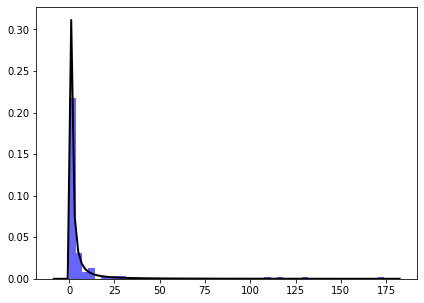

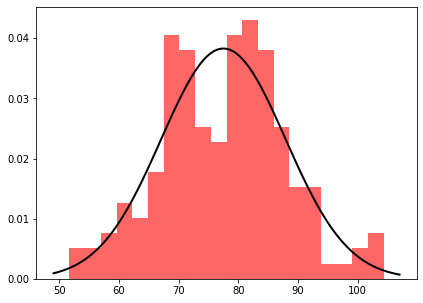

In [120]:
from scipy.stats import invgamma
from scipy.stats import norm

data=Sigma[:,0]
a, loc, scale = invgamma.fit(data)


plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.hist(data, bins=50, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = invgamma.pdf(x, a, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
#plt.title(title)

data=Mu[:,3]
loc, scale= norm.fit(data)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 2)
plt.hist(data, bins=20, density=True, alpha=0.6, color='r')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, loc, scale)
plt.plot(x, p, 'k', linewidth=2)


Les distributions empiriques correspondent bien aux distributions conditionnelles théoriques attendues. 

### **Remarque**
N'avons presque pas de burn-in ici puisque nous initialisons nos paramètres en fonction de notre image afin de pallier à la trop grande complexité d'un bon modèle. 

En effet nous remarquons qu'une bonne compression n'est possible seulement sur une image de grande dimension (minimum 60 X 60) qui est très lourde.
Nous avons ainsi tester sur de telles images pour nous assurer de la bonne performance des modèles mais choisissons ici de déterminer l'initialisation afin d'accélérer les observations.   

**Par exemple** : *un modèle avec une image de 60x60 et 200 itérations met au moins une heure à tourner.*

Vous pouvez retrouver plus loin le modèle pour une image plus complexe en plus grande dimension. (Partie Compression sur une image 60x60)

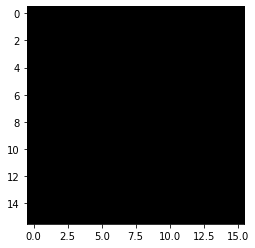

In [121]:
im =X[-1].reshape((16,16))
plt.imshow(im,cmap='gray')

### On affiche ici la compression simulée qui ne correspond évidemment pas à l'image pour les raisons évoquées (dimension trop faible, doutes sur beta). C'est pourquoi nous allons générer la décompression sur une image parfaitement compressée manuellement. 

### **Décompression :**

La fonction ``reconstruct`` décompresse l'image selon : 
$$
Y_i \vert X_i=k\sim \mathcal{N}( \mu_{k},\,\sigma_{k}^{2}) 
$$ 

en affectant à $X_i$, $\mu_k$, $\sigma_k$ les paramètres simulés par notre algorithme. 

In [126]:
def reconstruct(x) : 
    res = []
    for i in range(n):
        new_y = np.random.normal(loc = Mu[-1, int(x[i])-1], scale = np.sqrt(Sigma[-1, int(x[i])-1])) 
        new_y = max(int(new_y),0)
        new_y = min(new_y, 255)
        res.append(new_y)
        
    plt.imshow(np.array(res).reshape((16,16)), cmap='gray')

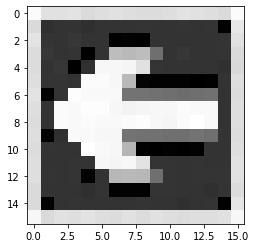

In [127]:
reconstruct(X[0])

 **La décompression correspond très bien à l'image, ainsi les $\mu_k$ et $\sigma_k^2$ sont très bien simulés.**

In [124]:
def reconstruct2(x) : # on regarde si les mu_k générés ressemblent bien au k en n'ajoutant aucune nuance
    res = []
    for i in range(n):
        new_y = Mu[0, int(x[i])-1]
        res.append(new_y)
        
    plt.imshow(np.array(res).reshape((16,16)), cmap='gray')

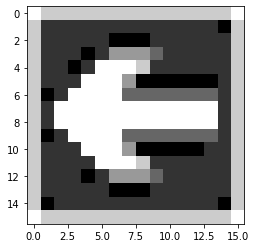

In [125]:
reconstruct2(X[0])

## **Compression sur une image 60 x 60**

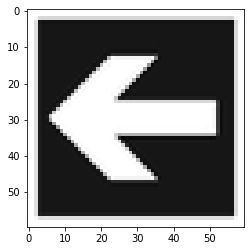

In [129]:
img=Image.open("fleche.jpg")
img.thumbnail((60,60), Image.ANTIALIAS)  
gray_image = ImageOps.grayscale(img)
plt.imshow(gray_image,cmap='gray')
y = np.array(gray_image)
y = y.reshape(y.shape[0]*y.shape[1]) 

In [145]:
# hyperparamètres
K = 13
beta = 5
n_iter = 10
n=60*60
sqrt_n = 60

#initialisation et paramètres des lois à priori
m = np.array([1.0]*K)
m = np.arange(0,256,256/K)
s = np.array([0.5]*K)
alphas =  np.array([1.0]*K)
betas = np.array([1.0]*K)
x = np.random.randint(K+1, size=n)
x = ((y /256)*K).astype(int)+1

# on prépare les tableaux pour stocker les simulations
Mu = np.zeros((n_iter,K))
Sigma = np.zeros((n_iter,K))
X = np.zeros((n_iter, n))

Mu[0, :] = m.copy()
Sigma[0,:] = s.copy()
X[0,:] = x.copy()

w=[]

In [146]:
for it in tqdm(range(1, n_iter)) :

  #on génère les x_i
  w=[]
  #on calcule les poids associés aux y_i
  for i in range(n):
    mu = Mu[it-1, x[i]-1].copy()
    sigma = Sigma[it-1, x[i]-1].copy()
    densité_y_i = stats.norm.pdf(y[i], loc = mu, scale =  sigma)
    

    w.append( densité_y_i )
  for i in range(n) :
    new_x_i = generate_potts(x, i, weights = w)
    x[i] = new_x_i.copy()
  X[it, :] = x.copy()

  # les mu_k et les sigma_k
  n_k = [np.sum(x==k) for k in range(1,K+1)]
  for k in range(K):
    F_k = 0
    Sigma_k = ( s[k] * Sigma[it-1, k] ) / ( Sigma[it-1, k] + s[k] * n_k[k] ).copy()

    F_k += (m[k] / s[k]).copy()
    F_k += (np.sum(y[x==(k+1)]) / Sigma[it-1, k]).copy()
    moy = (Sigma_k * F_k).copy()
    var = Sigma_k.copy()
    new_mu_k = (np.random.normal(loc = moy, scale= np.sqrt(var)))

    Mu[it, k] = new_mu_k

    new_alpha = (alphas[k] + n_k[k] / 2).copy()
    new_beta = (betas[k] + float(n_k[k])*np.sum((y[x==(k+1)] - new_mu_k)**2) / 2).copy()
    new_sigma_k = (stats.invgamma.rvs(new_alpha, scale = new_beta))
    Sigma[it, k] = new_sigma_k.copy()

100%|██████████| 9/9 [00:30<00:00,  3.42s/it]


### **Exemple de compression avec une image de dimension intermédiaire de 60x60 qui présente un résultat satisfaisant.** 

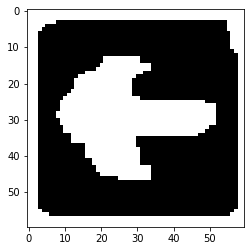

In [147]:
im =X[-1].reshape((60,60))
plt.imshow(im,cmap='gray')

## **Estimation de $\beta$**

Comme nous l'avons vu dans l'introduction, le paramètre $\beta$ et la probabilité $\pi(x \vert \beta)$ s'exprime selon la constante de normalisation : 
$$Z(\beta) = \sum_{x \in {1 ... K}} \exp  [ \beta \sum_{i=1}^n \sum_{j\ne i} \mathbb{1}(x_i=x_j) \mathbb{1}(i \sim j) ]
$$

Or on ne sait pas expliciter $Z(\beta)$ à partir de cette forme. En cause, notamment la croissance exponentielle du nombre d'opérandes selon $X$.  

C'est pourquoi le Gibbs Sampling est une méthode qui permet, en fixant $\beta$, de surmonter cette difficulté. 


Cependant fixer ce paramètre nuit aux simulations des autres paramètres puisque celui-ci dépend grandement de la structure de l'image et est difficile à chosir. En effet comme décrit en introduction, un $\beta$ faible conduira à une compression plus aléatoire tandis qu'un $\beta$ trop élevé produira une compression par bloc, trop "déterministe". Ainsi $\beta$ est un paramètre crucial dans l'analyse d'images qu'il est délicat de choisir par intuition. 

Une possibilité est donc de garder l'approche bayésienne afin d'estimer $\beta$ conditionnellement à notre modèle. Pour cela, nous proposons d'utiliser la loi a priori suivante : \\

$$
f(\beta) \sim \mathcal{U}_{[0,\beta_{max}]}(\beta)
\tag{8}
$$ \\

Nous fixons $\beta_{max}$ = 10.

Nous obtenons alors la loi (conditionnellement à notre modèle) suivante : 

$$
f(\beta \vert x) \sim \pi(x\vert \beta)f(\beta)
\tag{9}
$$ \\

Cette loi dépendant de $\beta$ on peut penser à l'introduire dans le Gibbs Sampler afin de calculer chaque $\beta^{(t)}$ selon $\beta^{(t-1)}$. Cependant la loi conditionnelle dépend encore de la constante $Z(\beta^{(t-1)})$ que l'on ne sait pas calculer. 

Il s'agit alors de trouver une stratégie pour isoler $\beta$ sans calculer $Z(\beta)$.

Nous proposons alors d'utiliser un algorithme de Metropolis-Hasting. En effet ce dernier, en plus de simuler  notre paramètre par itération sur sa loi conditionnelle, nous permet de fixer un **seuil d'acceptance** : 

$$\alpha (\beta \vert \beta^*) = min \{1, \frac{P(\beta^* \vert X)Q(\beta)}{P(\beta \vert X)Q(\beta^*)}\}$$

On simule à chaque itération un nouveau $\beta^*$. Celui-ci est accepté avec la probabilité $\alpha (\beta \vert \beta^*)$ tel que $\beta^{(t)}$ =  $\beta^*$. 

A l'inverse on rejete cette nouvelle simulation avec une probabilité de  $1 - \alpha (\beta \vert \beta^*)$. On a dans ce cas, $\beta^{(t)}$ =  $\beta^{(t-1)}$. 

Dans notre cas, d'après $(9)$, nous obtenons le ratio suivant : 

$$\alpha (\beta \vert \beta^*) = min \{1, \frac{\pi(X \vert \beta^*)f(\beta^*)Q(\beta^{(t-1)} \vert \beta^*)}{\pi(X \vert \beta^{(t-1)})f(\beta^{(t-1)})Q(\beta^* \vert \beta^{(t-1)})}\}$$

où $\beta^* \sim Q(\beta^* \vert \beta^{(t-1)}) $

La littérature sur le sujet propose dès lors de simplifier le rapport contenant la constante $Z(\beta)$ en établissant une zone d'étude permettant de simplifier l'étude de l'image. En effet ceux-ci considèrent généralement la notion de voisinage au regard de tous les pixels de l'image. Dans notre cas nous n'avons pas besoin de considérer cette zone de contrainte puisque nous ne travaillons que sur les pixels adjacents. 

L'article [4] propose d'utiliser pour $Q(\beta^* \vert \beta^{(t-1)})$ la loi suivante : \\


$$ \beta^* \sim \mathcal{N}_{[0,\beta_{max}]}(\beta^{(t-1)} , s_{\beta}^2)$$ \\

**Dès lors, nous obtenons l'algorithme de Gibbs suivant :**
 

> 1. On initialise $(\theta^{(0)},x^{(0)},\beta^{(0)})$ \\

> 2. Pour $t=1$ jusqu'à ``n_iter`` : \\

* on génère $X^{(t)} \text{ selon } \pi(x| \theta^{(t-1)},\beta^{(t-1)},x^{(t-1)}, y))$ \\

* on génère $\theta^{(t)}\text{ selon } f(\theta | \theta^{(t-1)},\beta^{(t-1)},x^{(t)},y )$


* on génère $ \beta^{(t)}$ selon l'algorithme MH suivant :
 * on génère $\beta^* \sim \mathcal{N}_{[0,\beta_{max}]}(\beta^{(t-1)} , s_{\beta}^2) $ 
  * on pose le ```ratio``` = $\alpha (\beta^{(t)} \vert \beta^*)$
  * on simule $u \sim \mathcal{U}_{[0,1]}$
  * **si** (u < ```ratio```) **alors** :
      * $\beta^{(t)}$ =  $\beta^*$
  * **sinon**
      * $\beta^{(t)}$ =  $\beta^{(t-1)}$
    

## Sources :

* [1] https://hal.inria.fr/inria-00073678/document?fbclid=IwAR3xWsLepgh_E5G7Bs_FMNNDCIxDymfrJotjmf303HXGtZI_9EBoFV7vTpE

* [2] https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics?fbclid=IwAR1oSpbkF6J-isB__j-KcjD8HFYxIjAWioXRDM9PTYkMWj_MHPDQTYSifUE


* [3] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.46.4294&rep=rep1&type=pdf

* [4] M. Pereyra, N. Dobigeon, H. Batatia and J. Tourneret, "*Estimating the Granularity Coefficient of a Potts-Markov Random Field Within a Markov Chain Monte Carlo Algorithm*," in IEEE Transactions on Image Processing, vol. 22, no. 6, pp. 2385-2397, June 2013, doi: 10.1109/TIP.2013.2249076.